# Hurst

Coeficiente de Hurst = 0.9818


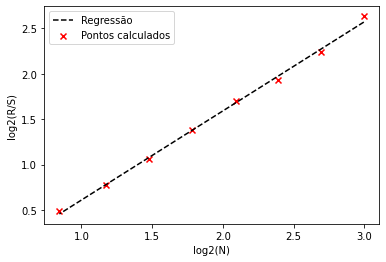

In [ ]:
# Hurst Expoent calculation

#-- Basics Library and Data import
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MESTRADO/VALE3.csv')
df['Date'] = pd.to_datetime(df['Date'])

Size_final = []
RS_final = []
obj_sample = df['Close'].to_numpy() 
size_max = len(obj_sample)
i = 1
while True:
  middle_process = []
  for obj_sample_sized in np.array_split(obj_sample, i,):
    actual_size = len(obj_sample_sized)
    mean = obj_sample_sized.mean()
    std = obj_sample_sized.std()
    Vk = (obj_sample_sized - mean).cumsum()
    range = Vk.max() - Vk.min()
    RS = range/std
    middle_process.append(RS)

  Size_final.append(len(Vk))
  RS_final.append(np.array(middle_process).mean())
  i = i*2
  if actual_size < 8:
    break

X_final = np.log10(Size_final)
Y_final = np.log10(RS_final)
z = np.polyfit(X_final, Y_final, 1)

print(f'Coeficiente de Hurst = {round(z[0],4)}')
plt.scatter(X_final,Y_final, label='Pontos calculados',marker = 'x',c='red')
plt.plot(X_final,z[0]*X_final + z[1],label='Regressão',linestyle = '--',c='black')
plt.xlabel('log2(N)')
plt.ylabel('log2(R/S)')
plt.legend()
plt.savefig('hurst_calc.eps', format='eps')






# Histórico

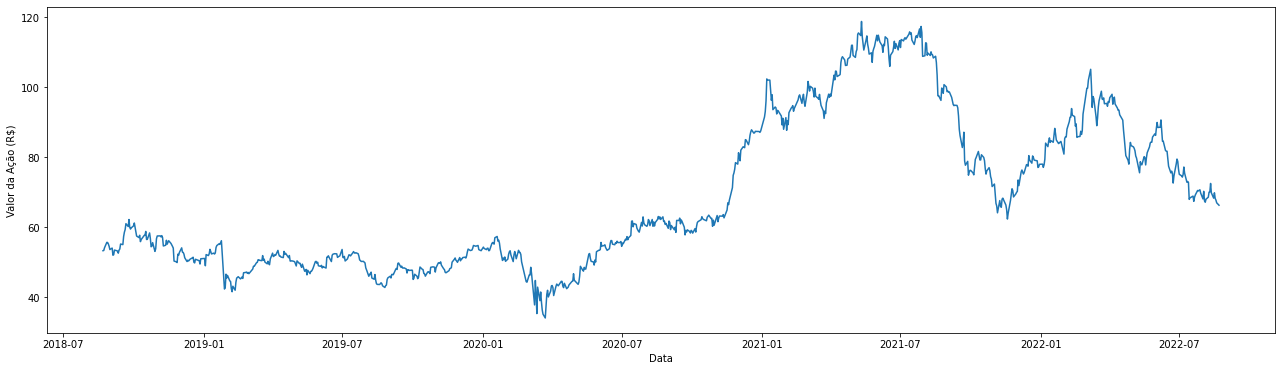

In [ ]:
# Gráfico dos dados históricos
plt.figure(figsize=(22,6))
sns.lineplot(data=df,x='Date',y='Close')
#plt.title('Preço diário das ações da VALE3 de 22/08/2018 até 22/08/2022')
plt.xlabel('Data')
plt.ylabel('Valor da Ação (R$)')
plt.savefig('full_time_series.eps', format='eps')

# Redes neurais

In [ ]:
#-- Basics Library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

#-- Metrics Calculation
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2

#-- Neural Network Toolbox
from sklearn.neural_network import MLPRegressor


#-- Warnings OFF
from warnings import simplefilter
simplefilter("ignore", FutureWarning)
simplefilter("ignore")
np.seterr(all="ignore")

#-- Function to build a narmax table with inputs (look_back size) and outputs (vec_num)
def build_narmax_full_table_vec(values_list,look_back,vec_num=1):
  list_aux = []
  for i in range(0, len(values_list) - (look_back + vec_num) + 1):
    up_lim = i + (look_back + vec_num)
    list_aux.append(values_list[i:up_lim])

  df_aux = pd.DataFrame(list_aux)
  return df_aux

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MESTRADO/VALE3.csv')

df['Date'] = pd.to_datetime(df['Date'])

vec_num = 1 # Output size
look_back = 10 # Input size

test = build_narmax_full_table_vec(values_list=df['Close'].to_list(),look_back=look_back,vec_num=vec_num)

train_size = int(len(test) - 90) # 90 dias de predição no futuro
X_train, y_train = test.iloc[:train_size,:-vec_num],test.iloc[:train_size,-vec_num:]
X_test, y_test = test.iloc[train_size+1:,:-vec_num],test.iloc[train_size+1:,-vec_num:]


model = MLPRegressor(random_state=0,
                   max_iter=1000,
                   batch_size=1,
                   shuffle=False,
                   learning_rate_init=0.2, 
                   tol=0.0000001, verbose=True,
                   solver='lbfgs',
                   learning_rate='adaptive',
                   hidden_layer_sizes=(10,7),
                   activation='relu'
                   )
start = time()
model.fit(X_train, y_train)
pred_df = y_test.copy()
pred_df.columns = ['true']
pred_df['pred'] = model.predict(X_test)

pred_df['index'] = y_test.index

print(f'''
LOSS: {model.loss_}
Training time: {round(time() - start,2)}
MAE: {MAE(pred_df['true'],pred_df['pred'])}
MSE: {MSE(pred_df['true'],pred_df['pred'])}
R2: {R2(pred_df['true'],pred_df['pred'])}
''')


plt.figure(figsize=(12,12))
sns.lineplot(data=pred_df,x='index',y='true',label='True',c='r')
sns.lineplot(data=pred_df,x='index',y='pred',label='Prediction',c='#999999')
plt.xlabel('Time point index from initial data (18/08/19)')
plt.ylabel('Close value prediction VALE3')
plt.legend()
plt.savefig('prediction_plot_python_config3.eps', format='eps')


def reg_plot(y_true,y_pred,name):
  R2_val = R2(y_true,y_pred)
  sns.scatterplot(x = y_true,y = y_pred,marker='x',label='Data')
  y_max = y_true.max()
  y_min = y_true.min()
  limit_point = [y_min, y_max]
  
  plt.plot(limit_point,limit_point, label='Identity')

  z = np.polyfit(y_true, y_pred, 1)
  plot_point = np.arange(y_min, y_max+5,5)
  plt.plot(plot_point,z[0]*plot_point + z[1],label='Fit',linestyle = '--',c='black')
  plt.title('{} - Rˆ2: {}'.format(name, round(R2_val,4)))
  plt.xlabel('Target')
  plt.ylabel('Output')
  plt.legend()


plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
reg_plot(y_train.iloc[:,-1],model.predict(X_train),'Train')

plt.subplot(2,2,2)
reg_plot(y_test.iloc[:,-1],model.predict(X_test),'Test')

plt.subplot(2,2,3)
reg_plot(test.iloc[:,-1],model.predict(test.iloc[:,:-vec_num]),'All')

plt.savefig('regression_plot_python_config3.eps', format='eps')




TypeError: ignored


LOSS: 14.949214455074666
Training time: 23.14
MAE: 7.007811923706263
MSE: 69.63067558643593
R2: 0.31502337565620986



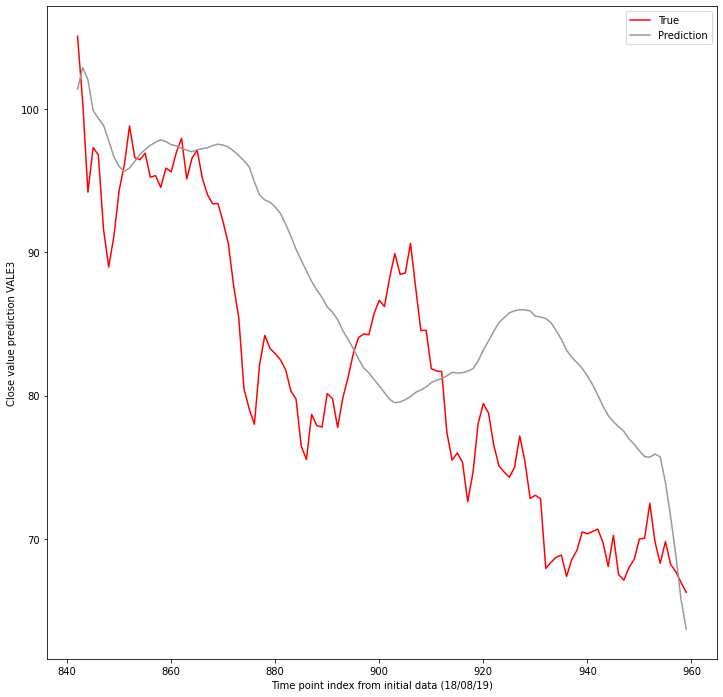

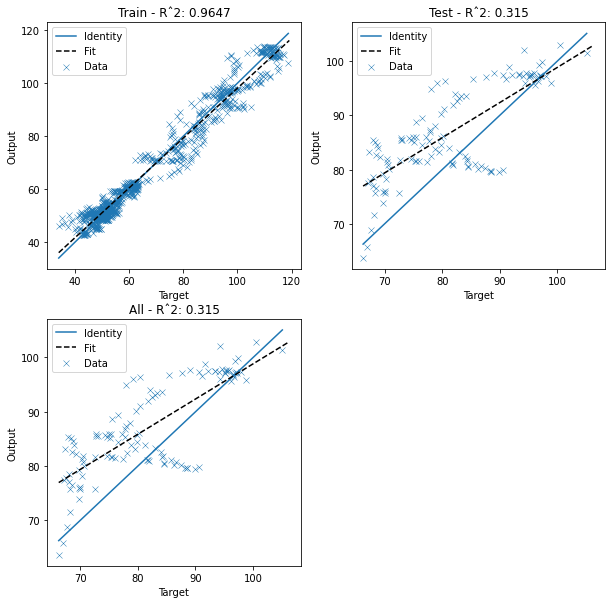

In [ ]:
#-- Basics Library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

#-- Metrics Calculation
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2

#-- Neural Network Toolbox
from sklearn.neural_network import MLPRegressor


#-- Warnings OFF
from warnings import simplefilter
simplefilter("ignore", FutureWarning)
simplefilter("ignore")
np.seterr(all="ignore")

#-- Function to build a narmax table with inputs (look_back size) and outputs (vec_num)
def build_narmax_full_table_vec(values_list,look_back,vec_num=1):
  list_aux = []
  for i in range(0, len(values_list) - (look_back + vec_num) + 1):
    up_lim = i + (look_back + vec_num)
    list_aux.append(values_list[i:up_lim])

  df_aux = pd.DataFrame(list_aux)
  return df_aux

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MESTRADO/VALE3.csv')

df['Date'] = pd.to_datetime(df['Date'])

vec_num = 30 # Output size
look_back = 30 # Input size

test = build_narmax_full_table_vec(values_list=df['Close'].to_list(),look_back=look_back,vec_num=vec_num)

train_size = int(len(test) - 90) # 90 dias de predição no futuro
X_train, y_train = test.iloc[:train_size,:-vec_num],test.iloc[:train_size,-vec_num:]
X_test, y_test = test.iloc[train_size+1:,:-vec_num],test.iloc[train_size+1:,-vec_num:]


model = MLPRegressor(random_state=0,
                   max_iter=100000000,
                   max_fun=100000000,
                   batch_size=1,
                   shuffle=False,
                   learning_rate_init=0.2, 
                   tol=0.00000000001, verbose=True,
                   solver='lbfgs',
                   learning_rate='adaptive',
                   hidden_layer_sizes=(50,50),
                   activation='relu'
                   )
start = time()
model.fit(X_train, y_train)



def reverse_narmax_result(y_test,y_pred):

  base_index = y_test.index.min()
  y_test.reset_index(drop=True,inplace=True)
  y_pred.reset_index(drop=True,inplace=True)
  val_list = np.zeros(y_test.shape[0]+y_test.shape[1] - 1)
  val_list_pred = np.zeros(len(val_list))

  for i in range(y_test.shape[0]):
    val_list[i:i+vec_num] += y_test.loc[i].to_numpy()
    val_list_pred[i:i+vec_num] += y_pred.loc[i].to_numpy()

  div_i = 1
  flag = True
  for i in range(len(val_list)):
    val_list[i] = val_list[i]/div_i
    val_list_pred[i] = val_list_pred[i]/div_i
    if flag:
      if div_i < vec_num:
        div_i += 1

    if len(val_list) - i < vec_num+1:
      flag = False
      div_i -= 1

  df_pred = pd.DataFrame({'true':val_list, 'pred':val_list_pred})

  df_pred.index = df_pred.index + base_index
  df_pred['index'] = df_pred.index
  return df_pred

y_pred = pd.DataFrame(model.predict(X_test))
df_pred = reverse_narmax_result(y_test,y_pred)

print(f'''
LOSS: {model.loss_}
Training time: {round(time() - start,2)}
MAE: {MAE(df_pred['true'],df_pred['pred'])}
MSE: {MSE(df_pred['true'],df_pred['pred'])}
R2: {R2(df_pred['true'],df_pred['pred'])}
''')

plt.figure(figsize=(12,12))
sns.lineplot(data=df_pred,x='index',y='true',label='True',c='r')
sns.lineplot(data=df_pred,x='index',y='pred',label='Prediction',c='#999999')
plt.xlabel('Time point index from initial data (18/08/19)')
plt.ylabel('Close value prediction VALE3')
plt.legend()
plt.savefig('prediction_plot_python_config6.eps', format='eps')


def reg_plot(y_true,y_pred,name):
  R2_val = R2(y_true,y_pred)
  sns.scatterplot(x = y_true,y = y_pred,marker='x',label='Data')
  y_max = y_true.max()
  y_min = y_true.min()
  limit_point = [y_min, y_max]
  
  plt.plot(limit_point,limit_point, label='Identity')

  z = np.polyfit(y_true, y_pred, 1)
  plot_point = np.arange(y_min, y_max+5,5)
  plt.plot(plot_point,z[0]*plot_point + z[1],label='Fit',linestyle = '--',c='black')
  plt.title('{} - Rˆ2: {}'.format(name, round(R2_val,4)))
  plt.xlabel('Target')
  plt.ylabel('Output')
  plt.legend()




y_pred = pd.DataFrame(model.predict(X_train))
df_train = reverse_narmax_result(y_train,y_pred)


df_all = reverse_narmax_result(test.iloc[:,-vec_num:],pd.DataFrame(model.predict(test.iloc[:,:-vec_num])))

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
reg_plot(df_train['true'],df_train['pred'],'Train')

plt.subplot(2,2,2)
reg_plot(df_pred['true'],df_pred['pred'],'Test')

plt.subplot(2,2,3)
reg_plot(df_pred['true'],df_pred['pred'],'All')

plt.savefig('regression_plot_python_config6.eps', format='eps')



